## Optimal location for opening a new cafe alongside the Bangalore Metro

This notebook will be used for the capstone project that is to be completed as part of the IBM data science professional certificate


First, let's import the packages required for the analysis

In [1]:
import numpy as np 

import pandas as pd 

import json 

import requests 
from pandas.io.json import json_normalize 

import matplotlib.cm as cm
import matplotlib.colors as colors

from sklearn.cluster import KMeans

!conda install -c conda-forge folium=0.5.0 --yes 
import folium 

print('Libraries imported.')

Solving environment: done

## Package Plan ##

  environment location: /opt/conda/envs/Python36

  added / updated specs: 
    - folium=0.5.0


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    ca-certificates-2020.4.5.1 |       hecc5488_0         146 KB  conda-forge
    certifi-2020.4.5.1         |   py36h9f0ad1d_0         151 KB  conda-forge
    branca-0.4.0               |             py_0          26 KB  conda-forge
    python_abi-3.6             |          1_cp36m           4 KB  conda-forge
    folium-0.5.0               |             py_0          45 KB  conda-forge
    altair-4.1.0               |             py_1         614 KB  conda-forge
    openssl-1.1.1g             |       h516909a_0         2.1 MB  conda-forge
    vincent-0.4.4              |             py_1          28 KB  conda-forge
    ------------------------------------------------------------
                       

Let's now import the location data that has already been collected and stored in a csv file. Let's create a pandas dataframe to store it.

In [2]:
# The code was removed by Watson Studio for sharing.

In [3]:
df_loc = pd.read_csv(body)
df_loc.head()

,Name,Line,Latitude,Longitude
0,Attiguppe,Purple Line,12.961957,77.533582
1,Baiyappanahalli,Purple Line,12.990763,77.652468
2,Banashankari,Green Line,12.915649,77.573631
3,Bangalore City Railway Station,Purple Line,12.975814,77.565708
4,Chickpete,Green Line,12.966759,77.574782


Before going ahead, let's visualise the stations in a folium map so that we can get a better understanding

In [4]:
latitude = 12.9716
longitude = 77.5946

map_bnglr = folium.Map(location=[latitude, longitude], zoom_start=12)

# add markers to map
for lat, lng, station, line in zip(df_loc['Latitude'], df_loc['Longitude'], df_loc['Name'], df_loc['Line']):
    label = '{}'.format(station)
    if line == 'Green Line':
        marker = 'green'
    else:
        marker = 'purple' 
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color = marker,
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_bnglr)  
    
map_bnglr

## Collecting data using Foursquare API

In [5]:
# The code was removed by Watson Studio for sharing.

Let's define a function that can fetch the venues for each metro station

In [6]:
def getNearbyVenues(names, latitudes, longitudes, radius=1000):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        results = requests.get(url).json()["response"]['groups'][0]['items']

        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Metro Station', 
                  'Station Latitude', 
                  'Station Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [7]:
LIMIT = 100
bnglr_venues = getNearbyVenues(names=df_loc['Name'],
                                   latitudes=df_loc['Latitude'],
                                   longitudes=df_loc['Longitude']
                                  )

Attiguppe
Baiyappanahalli
Banashankari
Bangalore City Railway Station
Chickpete
Cubbon Park
Dasarahalli
Deepanjali Nagar
Halasuru
Hosahalli
Indiranagar
Jalahalli
Jayanagar
Jayaprakash Nagar
Krishna Rajendra Market
Lalbagh
Magadi Road
Mahalakshmi
Majestic
Mahatma Gandhi Road
Mysore Road
Nagasandra
National College
Peenya
Peenya Industry
Rajajinagar
Rashtrakavi Kuvempu Road
Rashtreeya Vidyalaya Road
Sampige Road
Sandal Soap Factory
Sir M. Visveshwarya
Swami Vivekananda Road
South End Circle
Srirampura
Trinity
Dr. B. R. Ambedkar Station, Vidhana Soudha
Vijayanagar
Yelachenahalli
Yeshwantpur
Goraguntepalya


In [8]:
print(bnglr_venues.shape)
bnglr_venues.head()

(1473, 7)


,Metro Station,Station Latitude,Station Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Attiguppe,12.961957,77.533582,By 2 coffee,12.964766,77.538865,Coffee Shop
1,Attiguppe,12.961957,77.533582,Dewaar,12.958419,77.525859,Seafood Restaurant
2,Attiguppe,12.961957,77.533582,KFC,12.960916,77.528130,Fried Chicken Joint
3,Attiguppe,12.961957,77.533582,Subway,12.960867,77.528058,Sandwich Place
4,Attiguppe,12.961957,77.533582,Cafe Coffee day,12.960790,77.528423,Café


In [9]:
len(bnglr_venues['Venue Category'].unique())

166

There are 166 unique venue categories in our dataset. Let's now find out the number of venues under each category in the metro stations.

In [10]:
bnglr_onehot = pd.get_dummies(bnglr_venues[['Venue Category']], prefix="", prefix_sep="")

bnglr_onehot['Metro Station Name'] = bnglr_venues['Metro Station'] 

fixed_columns = [bnglr_onehot.columns[-1]] + list(bnglr_onehot.columns[:-1])
bnglr_onehot = bnglr_onehot[fixed_columns]

In [11]:
bnglr_grouped_raw = bnglr_onehot.groupby('Metro Station Name').sum().reset_index()
df_line = df_loc[['Name', 'Line']]
df_line.rename(columns = {'Name':'Metro Station Name'}, inplace = True)

bnglr_grouped = bnglr_grouped_raw.merge(df_line, on = 'Metro Station Name', how ='left')
cols = bnglr_grouped.columns.tolist()
cols = cols [0:1] + cols[-1:] + cols[1:-1]
bnglr_grouped = bnglr_grouped[cols]
bnglr_grouped.head()

/opt/conda/envs/Python36/lib/python3.6/site-packages/pandas/core/frame.py:4025: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  return super(DataFrame, self).rename(**kwargs)


,Metro Station Name,Line,Accessories Store,Afghan Restaurant,Airport,American Restaurant,Andhra Restaurant,Arcade,Art Gallery,Arts & Crafts Store,...,Toy / Game Store,Train Station,Tram Station,Travel & Transport,Turkish Restaurant,Udupi Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Wine Bar,Women's Store
0,Attiguppe,Purple Line,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Baiyappanahalli,Purple Line,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Banashankari,Green Line,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2
3,Bangalore City Railway Station,Purple Line,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Chickpete,Green Line,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Data Analysis

There are two lines for the metro, the green line and the purple line. Initially let us see how the top 10 venues in each line is distributed among the stations in that line.

In [12]:
green = bnglr_grouped[bnglr_grouped['Line']=='Green Line']
df_green = green.append(green.sum(numeric_only = True).rename('Total'))
df_green = df_green.sort_values(by = 'Total', axis = 1, ascending = False, na_position = 'first')
df_green.drop(index = 'Total', columns = 'Line', inplace = True)
df_green.set_index('Metro Station Name', inplace = True)
df_green = df_green.iloc[:, :10].astype('int32')

In [13]:
purple = bnglr_grouped[bnglr_grouped['Line']=='Purple Line']
df_purple = purple.append(purple.sum(numeric_only = True).rename('Total'))
df_purple = df_purple.sort_values(by = 'Total', axis = 1, ascending = False, na_position = 'first')
df_purple.drop(index = 'Total', columns = 'Line', inplace = True)
df_purple.set_index('Metro Station Name', inplace = True)
df_purple = df_purple.iloc[:, :10].astype('int32')

In [14]:
import seaborn as sns
from matplotlib import pyplot as plt

Text(0.5, 1.0, 'Distribution of venues in the Green Line Metro Stations')

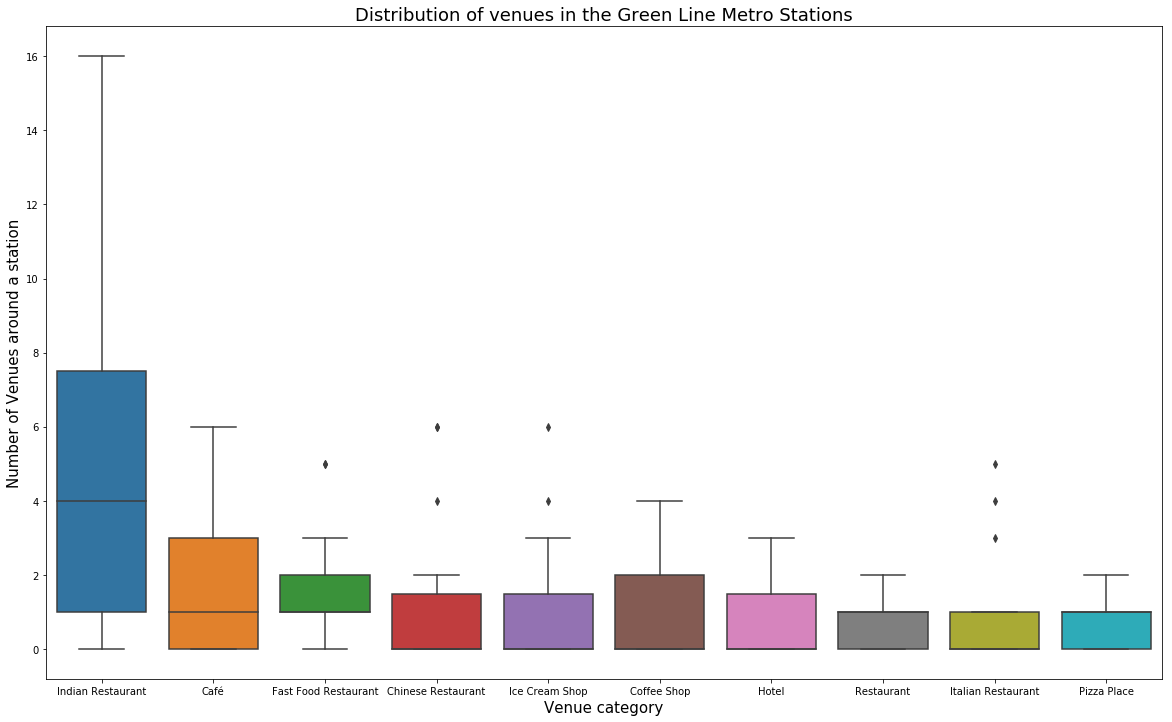

In [15]:
plt.figure(figsize=(20,12))
ax = sns.boxplot(data = df_green)
ax.set_xlabel('Venue category', fontsize=15)
ax.set_ylabel('Number of Venues around a station', fontsize=15)
ax.set_title('Distribution of venues in the Green Line Metro Stations', fontsize=18)

Text(0.5, 1.0, 'Distribution of venues in the Purple Line Metro Stations')

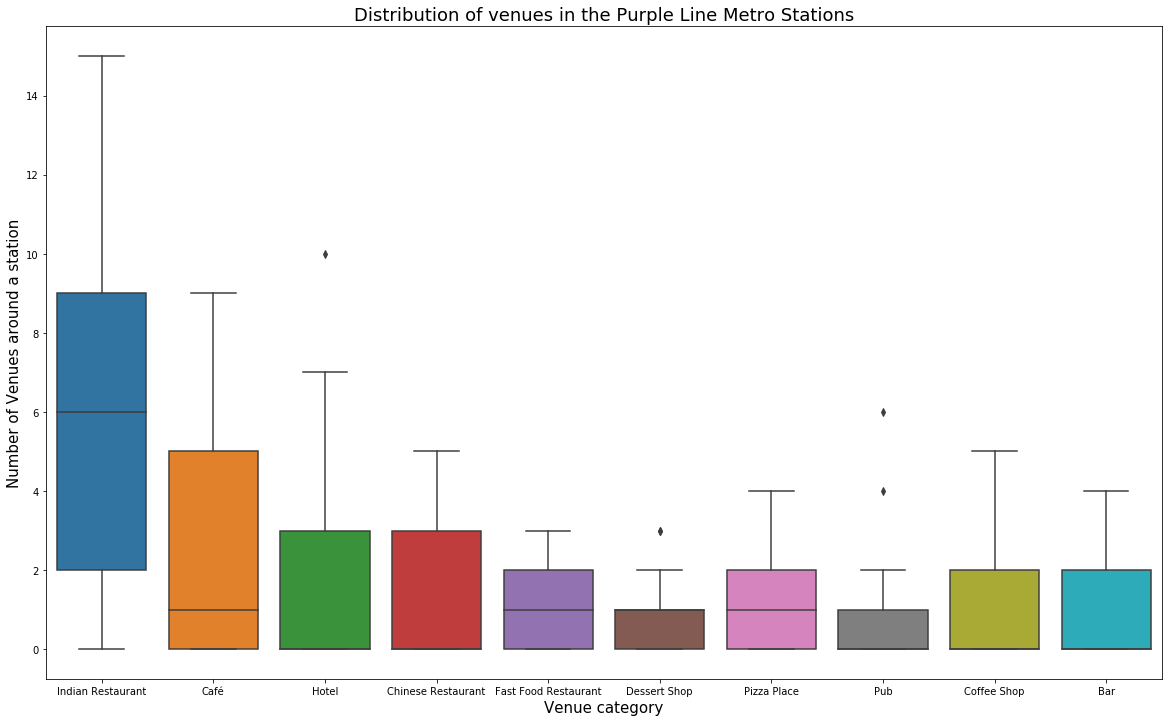

In [16]:
plt.figure(figsize=(20,12))
ax = sns.boxplot(data = df_purple)
ax.set_xlabel('Venue category', fontsize=15)
ax.set_ylabel('Number of Venues around a station', fontsize=15)
ax.set_title('Distribution of venues in the Purple Line Metro Stations', fontsize=18)

Now let's analyse the top venue categories for each metro station.

In [17]:
metro_grouped = bnglr_onehot.groupby('Metro Station Name').mean().reset_index()
metro_grouped.head()

,Metro Station Name,Accessories Store,Afghan Restaurant,Airport,American Restaurant,Andhra Restaurant,Arcade,Art Gallery,Arts & Crafts Store,Asian Restaurant,...,Toy / Game Store,Train Station,Tram Station,Travel & Transport,Turkish Restaurant,Udupi Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Wine Bar,Women's Store
0,Attiguppe,0.0,0.0,0.047619,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
1,Baiyappanahalli,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
2,Banashankari,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.095238
3,Bangalore City Railway Station,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
4,Chickpete,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000


Now let's print out the top 5 venue categories for each metro station

In [18]:
num_top_venues = 5

for station in metro_grouped['Metro Station Name']:
    print("----"+station+"----")
    temp = metro_grouped[metro_grouped['Metro Station Name'] == station].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Attiguppe----
                     venue  freq
0              Pizza Place  0.10
1              Coffee Shop  0.10
2       Seafood Restaurant  0.10
3  South Indian Restaurant  0.05
4             Dessert Shop  0.05


----Baiyappanahalli----
         venue  freq
0  Coffee Shop  0.12
1         Café  0.12
2          Gym  0.06
3     Platform  0.06
4   Donut Shop  0.06


----Banashankari----
               venue  freq
0  Indian Restaurant  0.19
1     Ice Cream Shop  0.14
2               Café  0.10
3      Women's Store  0.10
4      Jewelry Store  0.05


----Bangalore City Railway Station----
               venue  freq
0  Indian Restaurant  0.14
1      Metro Station  0.14
2           Platform  0.14
3          Rest Area  0.14
4  Electronics Store  0.14


----Chickpete----
               venue  freq
0  Indian Restaurant  0.46
1             Market  0.15
2      Historic Site  0.08
3          Rest Area  0.08
4         Restaurant  0.08


----Cubbon Park----
                venue  freq
0   Indian R

Let's now put the data into a pandas dataframe so that we can go ahead and implement the clustering alogrithm

In [19]:
#function to sort the venues in descending order

def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [20]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Metro Station Name']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
metro_venues_sorted = pd.DataFrame(columns=columns)
metro_venues_sorted['Metro Station Name'] = metro_grouped['Metro Station Name']

for ind in np.arange(metro_grouped.shape[0]):
    metro_venues_sorted.iloc[ind, 1:] = return_most_common_venues(metro_grouped.iloc[ind, :], num_top_venues)

metro_venues_sorted.head()

,Metro Station Name,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Attiguppe,Coffee Shop,Pizza Place,Seafood Restaurant,Ice Cream Shop,South Indian Restaurant,Indian Restaurant,Karnataka Restaurant,Fried Chicken Joint,Fast Food Restaurant,Dessert Shop
1,Baiyappanahalli,Coffee Shop,Café,Platform,Light Rail Station,Cafeteria,Mughlai Restaurant,Brewery,Sandwich Place,Donut Shop,Fast Food Restaurant
2,Banashankari,Indian Restaurant,Ice Cream Shop,Café,Women's Store,Hookah Bar,Jewelry Store,Breakfast Spot,Metro Station,Salad Place,Fast Food Restaurant
3,Bangalore City Railway Station,Platform,Indian Restaurant,Indie Movie Theater,Metro Station,Electronics Store,Fast Food Restaurant,Rest Area,Women's Store,Deli / Bodega,Donut Shop
4,Chickpete,Indian Restaurant,Market,Miscellaneous Shop,Rest Area,Historic Site,South Indian Restaurant,Restaurant,Farmers Market,Electronics Store,Donut Shop


## k-means clustering

For k-means clustering, we need to find the optimal value of k. Let's plot the distortion vs k plot to find that

Text(0.5, 1.0, 'Elbow Method to find the optimal k')

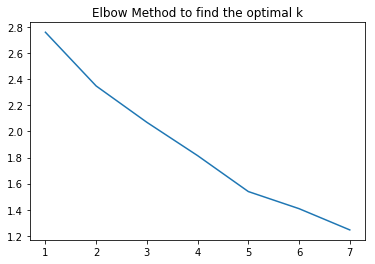

In [21]:
inertia = np.zeros((7,1))

metro_grouped_clustering = metro_grouped.drop('Metro Station Name', 1)

for i in range(1, 8):
    elbow = KMeans(n_clusters=i, random_state=0).fit(metro_grouped_clustering)
    inertia[i-1] = elbow.inertia_
    
plt.plot(np.arange(1,8), inertia)
plt.title('Elbow Method to find the optimal k')

Although there is no definitive elbow, the slope of the curve decreases from n = 5. So let's choose the number of clusters for our analysis as 5.

In [22]:
kmeans = KMeans(n_clusters=5, random_state=0).fit(metro_grouped_clustering)
kmeans.labels_[0:10] 

array([2, 2, 2, 2, 0, 2, 1, 4, 2, 1], dtype=int32)

Now let's create a new dataframe that includes the cluster as well as the top 10 venues for each metro station.

In [25]:
metro_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

bnglr_merged = df_loc.rename(columns={'Name':'Metro Station Name'})

bnglr_merged = bnglr_merged.join(metro_venues_sorted.set_index('Metro Station Name'), on='Metro Station Name')

bnglr_merged.head() 

,Metro Station Name,Line,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Attiguppe,Purple Line,12.961957,77.533582,2,Coffee Shop,Pizza Place,Seafood Restaurant,Ice Cream Shop,South Indian Restaurant,Indian Restaurant,Karnataka Restaurant,Fried Chicken Joint,Fast Food Restaurant,Dessert Shop
1,Baiyappanahalli,Purple Line,12.990763,77.652468,2,Coffee Shop,Café,Platform,Light Rail Station,Cafeteria,Mughlai Restaurant,Brewery,Sandwich Place,Donut Shop,Fast Food Restaurant
2,Banashankari,Green Line,12.915649,77.573631,2,Indian Restaurant,Ice Cream Shop,Café,Women's Store,Hookah Bar,Jewelry Store,Breakfast Spot,Metro Station,Salad Place,Fast Food Restaurant
3,Bangalore City Railway Station,Purple Line,12.975814,77.565708,2,Platform,Indian Restaurant,Indie Movie Theater,Metro Station,Electronics Store,Fast Food Restaurant,Rest Area,Women's Store,Deli / Bodega,Donut Shop
4,Chickpete,Green Line,12.966759,77.574782,0,Indian Restaurant,Market,Miscellaneous Shop,Rest Area,Historic Site,South Indian Restaurant,Restaurant,Farmers Market,Electronics Store,Donut Shop


Now let's visualise the resulting clusters

In [26]:
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

kclusters = 5

x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]


markers_colors = []
for lat, lon, poi, cluster in zip(bnglr_merged['Latitude'], bnglr_merged['Longitude'], bnglr_merged['Metro Station Name'], bnglr_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

## Examining the clusters

Now let's examine each cluster and find out what they represent and then evaluate which cluster would be best for starting a new cafe

#### Cluster 1

In [27]:
bnglr_merged.loc[bnglr_merged['Cluster Labels'] == 0, bnglr_merged.columns[[0] + list(range(5, bnglr_merged.shape[1]))]]

,Metro Station Name,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
4,Chickpete,Indian Restaurant,Market,Miscellaneous Shop,Rest Area,Historic Site,South Indian Restaurant,Restaurant,Farmers Market,Electronics Store,Donut Shop
14,Krishna Rajendra Market,Indian Restaurant,Flower Shop,General Entertainment,Market,South Indian Restaurant,Garden Center,Miscellaneous Shop,Fast Food Restaurant,Paper / Office Supplies Store,Park
18,Majestic,Indian Restaurant,Hotel,Bed & Breakfast,Platform,Bus Station,Rest Area,Restaurant,Dessert Shop,Electronics Store,Seafood Restaurant
30,Sir M. Visveshwarya,Indian Restaurant,Hotel,Karnataka Restaurant,Bus Station,Dessert Shop,Restaurant,Miscellaneous Shop,Seafood Restaurant,Bookstore,Park


#### Cluster 2

In [28]:
bnglr_merged.loc[bnglr_merged['Cluster Labels'] == 1, bnglr_merged.columns[[0] + list(range(5, bnglr_merged.shape[1]))]]

,Metro Station Name,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
6,Dasarahalli,Shopping Mall,Fast Food Restaurant,Multiplex,Resort,Karnataka Restaurant,Deli / Bodega,Farmers Market,Electronics Store,Donut Shop,Diner
11,Jalahalli,Light Rail Station,Resort,Karnataka Restaurant,Metro Station,Multiplex,Department Store,Bus Station,Fast Food Restaurant,Shopping Mall,Indian Restaurant
24,Peenya Industry,Fast Food Restaurant,Indian Restaurant,Light Rail Station,Bus Station,Train Station,Multiplex,Shopping Mall,Coffee Shop,Cocktail Bar,Clothing Store
38,Yeshwantpur,Hotel,Bus Station,Fast Food Restaurant,Market,Multiplex,Restaurant,Movie Theater,Breakfast Spot,Miscellaneous Shop,Farmers Market
39,Goraguntepalya,Fast Food Restaurant,Hotel,Bar,Punjabi Restaurant,Multiplex,Department Store,Restaurant,Miscellaneous Shop,Seafood Restaurant,Chinese Restaurant


#### Cluster 3

In [29]:
bnglr_merged.loc[bnglr_merged['Cluster Labels'] == 2, bnglr_merged.columns[[0] + list(range(5, bnglr_merged.shape[1]))]]

,Metro Station Name,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Attiguppe,Coffee Shop,Pizza Place,Seafood Restaurant,Ice Cream Shop,South Indian Restaurant,Indian Restaurant,Karnataka Restaurant,Fried Chicken Joint,Fast Food Restaurant,Dessert Shop
1,Baiyappanahalli,Coffee Shop,Café,Platform,Light Rail Station,Cafeteria,Mughlai Restaurant,Brewery,Sandwich Place,Donut Shop,Fast Food Restaurant
2,Banashankari,Indian Restaurant,Ice Cream Shop,Café,Women's Store,Hookah Bar,Jewelry Store,Breakfast Spot,Metro Station,Salad Place,Fast Food Restaurant
3,Bangalore City Railway Station,Platform,Indian Restaurant,Indie Movie Theater,Metro Station,Electronics Store,Fast Food Restaurant,Rest Area,Women's Store,Deli / Bodega,Donut Shop
5,Cubbon Park,Indian Restaurant,Hotel,Chinese Restaurant,Café,Italian Restaurant,Dessert Shop,Lounge,Ice Cream Shop,Fast Food Restaurant,Bar
8,Halasuru,Café,Hotel,Department Store,Chinese Restaurant,Bar,Shopping Mall,Clothing Store,Indian Restaurant,Asian Restaurant,Bakery
9,Hosahalli,Indian Restaurant,Fast Food Restaurant,Snack Place,Department Store,Ice Cream Shop,Multiplex,Bus Station,Playground,Platform,Pizza Place
10,Indiranagar,Indian Restaurant,Café,Pub,Chinese Restaurant,Bar,Bakery,Lounge,Ice Cream Shop,Dessert Shop,Cocktail Bar
12,Jayanagar,Indian Restaurant,Chinese Restaurant,Café,Hotel,Lounge,Juice Bar,Coffee Shop,Electronics Store,Restaurant,Salon / Barbershop
13,Jayaprakash Nagar,Food Truck,Pizza Place,Department Store,Café,Liquor Store,Sandwich Place,Bakery,Gas Station,Pub,Breakfast Spot


#### Cluster 4

In [30]:
bnglr_merged.loc[bnglr_merged['Cluster Labels'] == 3, bnglr_merged.columns[[0] + list(range(5, bnglr_merged.shape[1]))]]

,Metro Station Name,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
21,Nagasandra,Gas Station,Light Rail Station,Athletics & Sports,Bakery,Women's Store,Dessert Shop,Fish Market,Fast Food Restaurant,Farmers Market,Electronics Store


#### Cluster 5

In [31]:
bnglr_merged.loc[bnglr_merged['Cluster Labels'] == 4, bnglr_merged.columns[[0] + list(range(5, bnglr_merged.shape[1]))]]

,Metro Station Name,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
7,Deepanjali Nagar,Metro Station,Indian Restaurant,Smoke Shop,Travel & Transport,Department Store,Bus Station,Deli / Bodega,Fast Food Restaurant,Farmers Market,Electronics Store
20,Mysore Road,Metro Station,Travel & Transport,Train Station,Road,Deli / Bodega,Fast Food Restaurant,Farmers Market,Electronics Store,Donut Shop,Diner
37,Yelachenahalli,Department Store,Indian Restaurant,Pizza Place,Metro Station,Café,Women's Store,Fast Food Restaurant,Farmers Market,Electronics Store,Donut Shop


## Discussion and Findings

It can be seen that out of the 5 clusters, cluster 4 is a single member cluster which is more or less an outlier that is very different from the other metro stations. On analysing its characteristics, cluster 4 doesn't seem to be a good candidate for opening a new cafe. Cluster 5 also represents a less outgoing populace and is not a great fit for opening a new cafe.

Now coming to the other clusters, Cluster 3 which is the largest cluster with 27 members represent a group of metro stations that already has a large number of cafes in its vicinity (with cafes featuring as 2nd - 5th most occuring venue in almost all its members). So this cluster is also not a great candidate for our new cafe owing to the high competition that is already present.

The remaining 2 clusters (Cluster 1 and Cluster 2) have a thriving food culture but are not congested with a lot of cafes. And hence would be good candidates for opening a new cafe. Amongst the two clusters, cluster 1 represents a more urban and outgoing community (as evident from the type of venues that are prevalent) and hence would be the best choice for our new cafe.

| Cluster     | Description | Remarks       |
| :---        |    :----:   |          ---: |
| Cluster 1   | Urban centres with a thriving food culture, not congested with cafes       | Most preferred for opening a new cafe  |
| Cluster 2   | Not congested with cafes, but represent a less outgoing community    | Second most preferred   |
| Cluster 3   | Saturated with cafes    | Not a viable choice for opening a new cafe     |
| Cluster 4   | Outlier case with a single member        | -     |
| Cluster 5   | Lacks a strong food culture with very few F&B venues currently        | -   |

#### From our study, we would recommend cluseter 1 and cluster 2 as the optimal locations for opening a new cafe.

In [38]:
bnglr_merged.loc[bnglr_merged['Cluster Labels'] == 0 , bnglr_merged.columns[[0] + list(range(5, bnglr_merged.shape[1]))]]

,Metro Station Name,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
4,Chickpete,Indian Restaurant,Market,Miscellaneous Shop,Rest Area,Historic Site,South Indian Restaurant,Restaurant,Farmers Market,Electronics Store,Donut Shop
14,Krishna Rajendra Market,Indian Restaurant,Flower Shop,General Entertainment,Market,South Indian Restaurant,Garden Center,Miscellaneous Shop,Fast Food Restaurant,Paper / Office Supplies Store,Park
18,Majestic,Indian Restaurant,Hotel,Bed & Breakfast,Platform,Bus Station,Rest Area,Restaurant,Dessert Shop,Electronics Store,Seafood Restaurant
30,Sir M. Visveshwarya,Indian Restaurant,Hotel,Karnataka Restaurant,Bus Station,Dessert Shop,Restaurant,Miscellaneous Shop,Seafood Restaurant,Bookstore,Park


In [39]:
bnglr_merged.loc[bnglr_merged['Cluster Labels'] == 1 , bnglr_merged.columns[[0] + list(range(5, bnglr_merged.shape[1]))]]

,Metro Station Name,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
6,Dasarahalli,Shopping Mall,Fast Food Restaurant,Multiplex,Resort,Karnataka Restaurant,Deli / Bodega,Farmers Market,Electronics Store,Donut Shop,Diner
11,Jalahalli,Light Rail Station,Resort,Karnataka Restaurant,Metro Station,Multiplex,Department Store,Bus Station,Fast Food Restaurant,Shopping Mall,Indian Restaurant
24,Peenya Industry,Fast Food Restaurant,Indian Restaurant,Light Rail Station,Bus Station,Train Station,Multiplex,Shopping Mall,Coffee Shop,Cocktail Bar,Clothing Store
38,Yeshwantpur,Hotel,Bus Station,Fast Food Restaurant,Market,Multiplex,Restaurant,Movie Theater,Breakfast Spot,Miscellaneous Shop,Farmers Market
39,Goraguntepalya,Fast Food Restaurant,Hotel,Bar,Punjabi Restaurant,Multiplex,Department Store,Restaurant,Miscellaneous Shop,Seafood Restaurant,Chinese Restaurant
